In [92]:
using Cxx
using PyCall
using PyPlot

@pyimport imageio
@pyimport skimage.filters as filters
@pyimport skimage.morphology as morphology
disk = morphology.disk;

In [1089]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

In [47]:
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180330092923.mp4"
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

"/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

In [142]:
reader = imageio.get_reader(video_file);
#writer = imageio.get_writer("~/tmp/out.mp4", fps=reader[:get_meta_data]()["fps"]);

# frames = [T.preprocess_frame(reader[:get_data](i)) for i in 900:1400];
@time background = T.init_background(frames; max_iters=3);

134.522975 seconds (982.44 k allocations: 57.402 GiB, 3.19% gc time)


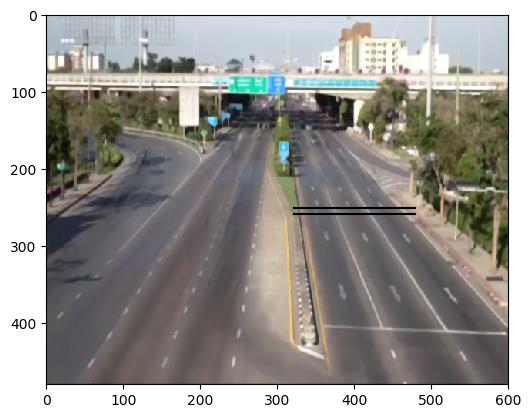

In [130]:
# slit_x = 285;
# slit_y = 200;
# slit_width = 80;
slit_x = 320;
slit_y = 250;
slit_width = 160;

block_width = 10;
block_height = 8;

imshow(background)
PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);

In [131]:
threshold = 0.05

0.05

In [905]:
include("src/StMrf.jl")
import StMrf
SM = StMrf;

include("src/Labeler.jl")
import Labeler
L = Labeler;

blocks = Array{SM.Block, 2}(floor(Int, size(background, 1) / block_height) - 1, floor(Int, size(background, 2) / block_width) - 1)
for row_id in 1:size(blocks, 1)
    const row_start = row_id * block_height;
    for col_id in 1:size(blocks, 2)
        const col_start = col_id * block_width;
        blocks[row_id, col_id] = SM.Block(col_start, row_start, block_width, block_height);
    end
end

slit_coords = [SM.get_block_coords(slit_x + i * block_width, slit_y, block_width, block_height) for i in 1:floor(Int, slit_width / block_width)]
slit_line = [blocks[c...] for c in slit_coords];

new_object_id = 1;
f_id = 400;

85

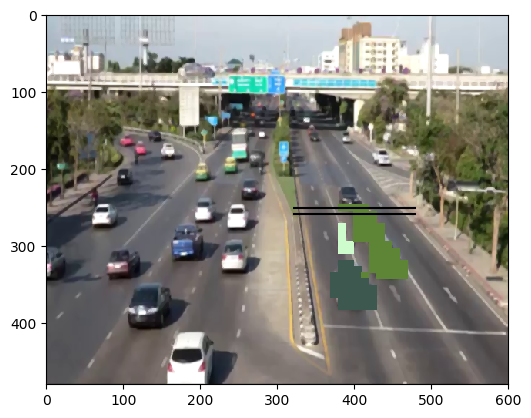

In [929]:
frame = frames[f_id];
# prev_pixel_map = zeros(Int, size(frame)[1:2])

for i in 1:1
    if f_id >= size(frames, 1)
        break
    end
    
    frame = frames[f_id];
    global prev_pixel_map = SM.blocks_to_object_map(blocks);
    SM.update_slit_objects!(blocks, slit_coords, frame, background, new_object_id; threshold=threshold);
    
    global old_frame = frame;
    frame = frames[f_id + 1];

    obj_ids_map = map(b -> b.object_id, blocks);

    global object_ids = sort(unique(obj_ids_map));
    object_ids = object_ids[object_ids .> 0]
    group_coords = [collect(zip(findn(obj_ids_map .== id)...)) for id in object_ids]
    global motion_vecs = [SM.find_motion_vector(blocks, frame, old_frame, gc) for gc in group_coords]
    
    if size(motion_vecs, 1) == 0
        f_id += 1
        continue
    end

    motion_vecs_rounded = [SM.round_motion_vector(mv, block_width, block_height) for mv in motion_vecs]
    global new_map = SM.update_object_ids(blocks, obj_ids_map, motion_vecs_rounded, group_coords, frame, background; 
                                   threshold=threshold);
    new_map[map(x -> x.end_y, blocks) .< slit_y] = Set();
    
    labels = L.label_map_gco(blocks, new_map, motion_vecs, prev_pixel_map, frame, old_frame);
    labels = Images.label_components(labels, trues(3, 3))
    new_object_id = maximum(labels) + 1
    SM.set_block_ids!(blocks, labels)
    
    f_id += 1
end

plot_frame = deepcopy(frame);
for b in blocks
    if b.object_id == 0
        continue
    end

    srand(b.object_id)

    plot_frame[b.y_inds(), b.x_inds(),1] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),2] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),3] .= rand()
end

T.plot_frame(plot_frame, slit_x, slit_y, slit_width, block_height);

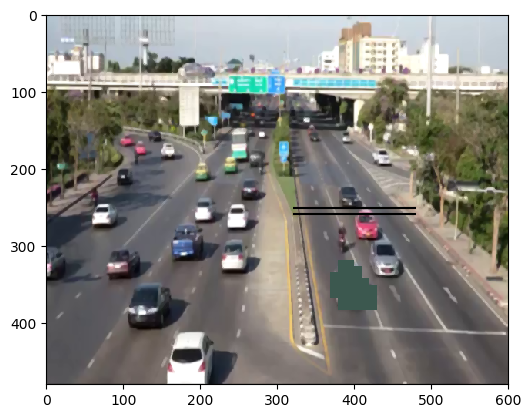

In [966]:
plot_frame = deepcopy(frame);
for b in blocks
    if b.object_id != 1
        continue
    end

    srand(b.object_id)

    plot_frame[b.y_inds(), b.x_inds(),1] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),2] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),3] .= rand()
end

T.plot_frame(plot_frame, slit_x, slit_y, slit_width, block_height);

Ideas:  
1. Ввести сигмоиду вместо порога на отличие от background. Определять background через GCO.
2. Сделать то же самое для теней.
3. Разбивать ещё и на компоненты связности, и каждой компоненте позволить иметь отдельный label. Добавить бонус за использование labels. Добавить штрафы за разницу в векторах.
4. Добавить слияние, описанное в статье

Кажется, что улучшения 1 и 2 помогут сделать разрыв в связности достаточно сильным признаком, что позволит ввести улучшение 3 с большим бонусом за новый label.

## Shadow suppression

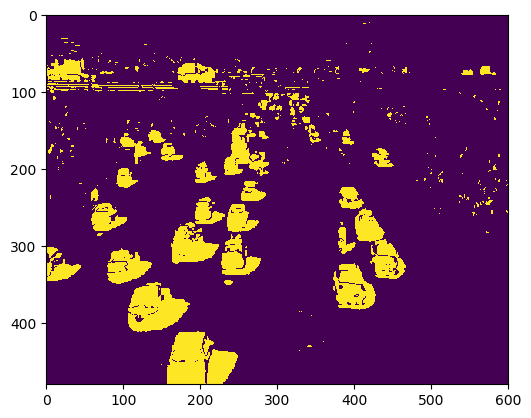

In [969]:
foreground = T.subtract_background(frame, background);
imshow(foreground);

In [1111]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

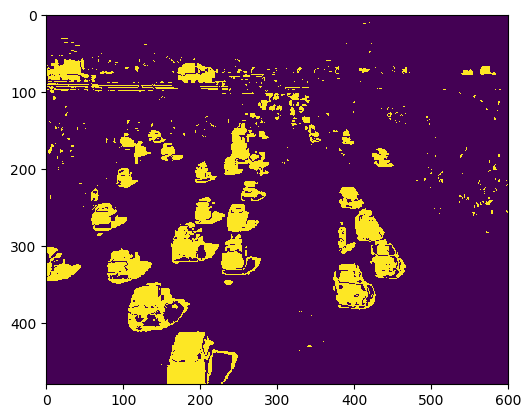

PyObject <matplotlib.image.AxesImage object at 0x7fc1708eee80>

In [1191]:
imshow(foreground .& .!T.shadow_mask(frame, background))

In [1200]:
@pyimport skimage.color as color

In [1318]:
include("src/GcWrappers.jl")

import GcWrappers
GW = GcWrappers;

import GCoptimization
GCO = GCoptimization;

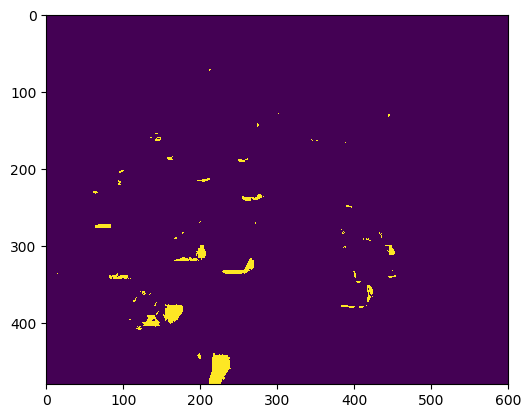

In [1347]:
imshow(data_energy .> 0.5);

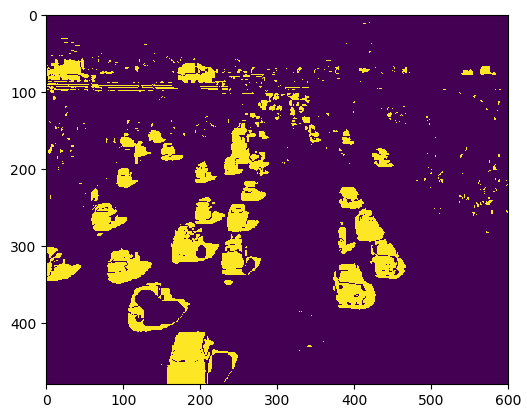

PyObject <matplotlib.image.AxesImage object at 0x7fc161f069e8>

In [1360]:
hsv_frame = color.rgb2hsv(frame);
hsv_backround = color.rgb2hsv(background);

h_threshold = 0.5
s_threshold = 0.05
min_ratio = 0.1
max_ratio = 0.5
scale = 10.0

v_ratio = hsv_frame[:,:,3] ./ hsv_backround[:,:,3];
h_cost = GW.sigmoid.(abs.(hsv_frame[:,:,1] .- hsv_backround[:,:,1]), h_threshold; scale=scale);
s_cost = GW.sigmoid.(hsv_frame[:,:,2] .- hsv_backround[:,:,2], s_threshold; scale=scale);
v_cost = sqrt.(GW.sigmoid.(v_ratio, min_ratio; scale=scale) .* GW.sigmoid.(max_ratio, v_ratio; scale=scale));
# v_cost = (min_ratio .<=  .<= max_ratio)
data_energy = v_cost .* h_cost .* s_cost .* foreground;
data_cost = GW.prob_to_score.(hcat(data_energy[:], max.(0, 0.3 .- data_energy[:])))

gco = GW.gc_optimization_8_grid_graph(size(frame)[1:2]..., 2);
GW.set_data_cost(gco, -data_cost .* 100)
GW.set_smooth_cost(gco, 2, penalty=10000)

GCO.gco_expansion(gco)
labels = reshape(GCO.gco_getlabeling(gco), size(frame)[1:2]);
imshow(foreground .& labels)

## MRF debug

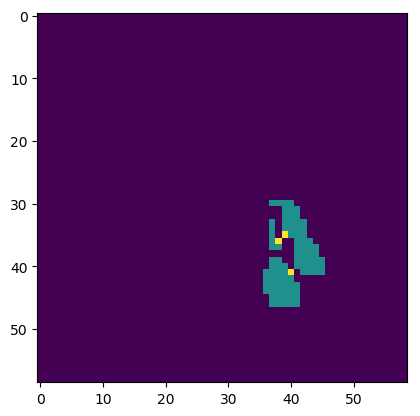

In [935]:
# imshow(prev_pixel_map);
imshow(map(length, new_map));

$U_N(N_{y_k})$: Pott's J = -$\alpha$;  
$M_{xy_k}$: number of overlapping pixel labels  
$D_{xy_k}$: image difference between a block in the previous frame and displaced block in the current frame;  

In [765]:
include("src/GcWrappers.jl")
import GcWrappers
GW = GcWrappers;

In [774]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

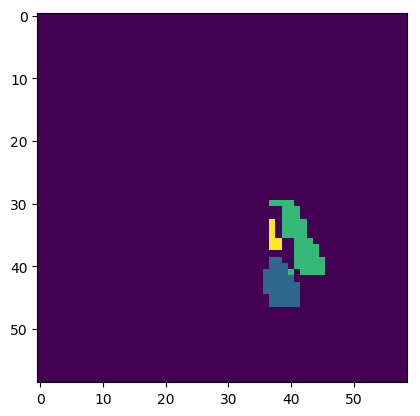

PyObject <matplotlib.image.AxesImage object at 0x7fc17ab70048>

In [936]:
imshow(L.label_map_gco(blocks, new_map, motion_vecs, prev_pixel_map, frame, old_frame))

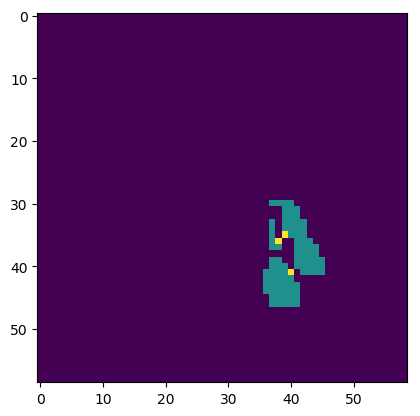

In [937]:
imshow(map(length, new_map));

In [938]:
tested_coords = collect(zip(findn(map(length, new_map) .> 1)...))

3-element Array{Tuple{Int64,Int64},1}:
 (37, 39)
 (36, 40)
 (42, 41)

In [940]:
new_map[tested_coords[3]...]

Set([2, 1])

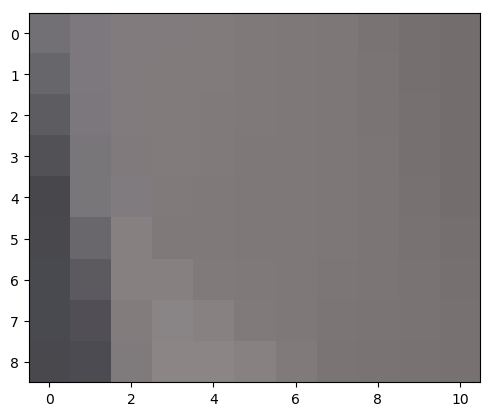

PyObject <matplotlib.image.AxesImage object at 0x7fc17ac24b70>

In [963]:
imshow(frame[block.coords()..., :])

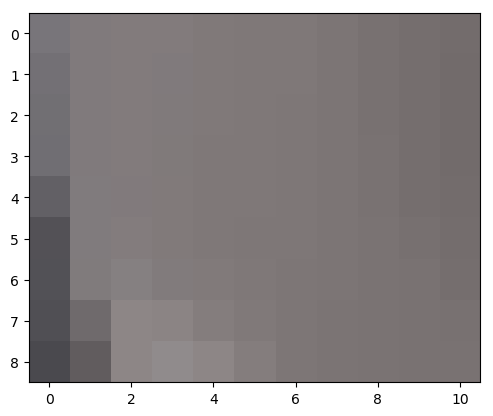

PyObject <matplotlib.image.AxesImage object at 0x7fc176211d30>

In [962]:
imshow(old_frame[block.coords(-1 .* motion_vecs[1])..., :])

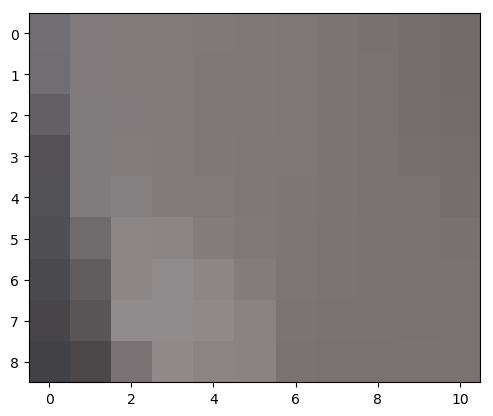

PyObject <matplotlib.image.AxesImage object at 0x7fc17aca82e8>

In [964]:
imshow(old_frame[block.coords(-1 .* motion_vecs[2])..., :])

In [960]:
obj_id = 2
block = blocks[tested_coords[3]...]

println([1 - cor(frame[block.coords()..., :][:], old_frame[block.coords(-1 .* motion_vecs[id])..., :][:]) for id in 1:2])
println([mean(abs.(frame[block.coords()..., :] .- old_frame[block.coords(-1 .* motion_vecs[id])..., :])) for id in 1:2])

println([mean(prev_pixel_map[block.coords(-1 .* motion_vecs[id])...] .!= id) for id in 1:2])

[0.134681, 0.0399572]
[0.0146168, 0.0116063]
[0.909091, 1.0]


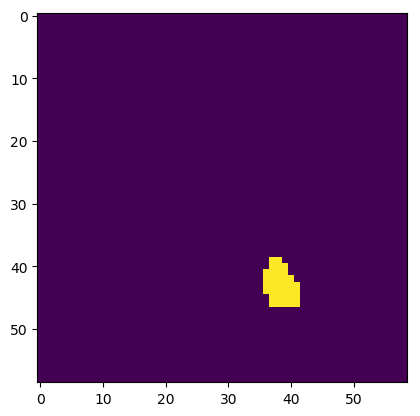

PyObject <matplotlib.image.AxesImage object at 0x7fc17a93db38>

In [959]:
# imshow(prev_pixel_map .== 1)
imshow(labels .== 1)

In [948]:
tested_ids = [GW.id_by_coords(c..., size(blocks, 1), zero_based=false) for c in tested_coords];
println(tested_ids)

[2279, 2337, 2402]


In [951]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];
L.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame)[tested_ids,1:3]

3×3 Array{Int64,2}:
 -1000000  -1190      -225
 -1000000   -213     -1034
    -1044  -1040  -1000000

In [952]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];
L.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame)[tested_ids,1:3]

3×3 Array{Int64,2}:
 -1000000  -1190      -225
 -1000000   -213     -1034
    -1044  -1040  -1000000